Author:
        
        PARK, JunHo, junho@ccnets.org

        
        KIM, JeongYoong, jeongyoong@ccnets.org
        
    COPYRIGHT (c) 2024. CCNets. All Rights reserved.

<a id="1"></a>
> <h1 style = 'font-family: Times New Roman'><b> <b style = 'color: #42c2f5'></b> Train CCNet with Titanic dataset</b></h1>

- Data Source: https://www.kaggle.com/competitions/titanic/data


### Experiment Objective:

The objective of this experiment is to demonstrate the conditional independence of modifying the learned latent causes \(E\) from the outcome \(Y\), given the current status \(X\), and to establish that \(Y\) and \(E\) are both necessary and sufficient causes for the causal generation of \(X\). Utilizing a model that has learned the probability distribution \(P(Y|X)\), this experiment aims to validate the model's ability to adapt to manipulated explanations and assess its impact on predictions and overall performance.

This approach is particularly beneficial in scenarios like healthcare, where understanding the specific conditions leading to a patient's outcome is crucial.

### Experiment Design:

The experimental setup includes four groups to observe the model’s response to different data variations:

- **Control Group**:
    - Uses the `original dataset` with basic preprocessing.
  
### Experimental Groups Description:

1. **Causal Explanation Group**:
    - Tests how the model performs with unaltered data by combining CCNet's `Explanation` with the original label, `y_true`.

2. **Shifted Explanation Group**:
    - Assesses the model's resilience using data generated with an `Explanation` sourced from another observational dataset, exploring its adaptability to new explanatory contexts.

3. **Hybrid Explanation Group**:
    - Evaluates how the model handles mixed explanations by combining half of CCNet’s original `Explanation` with half from the Shifted Explanation Group, used with `y_true`.

### Model Testing and Performance Evaluation:

- The model is tested on both the original and synthetic datasets to assess accuracy and F1 scores, evaluating the impact of explanation manipulation.

### Results Analysis:

- Performance metrics across all datasets are compared to determine the model's robustness and effectiveness in handling variations in explanatory data. This analysis will help confirm the model's ability to maintain performance under varying conditions.


<a id="1"></a>
> <h2 style = 'font-family: Times New Roman'><b> <b style = 'color: #42c2f5'>1.</b> Import Necessary Libraries </b></h2>

In [1]:
import os
import sys
import warnings
warnings.filterwarnings("ignore") # Ignore warnings

path_append = "../../"
sys.path.append(path_append)  # Go up one directory from where you are.

# Set random seed for reproducibility
from nn.utils.init import set_random_seed
set_random_seed(0) 

<a id="1"></a>
> <h3 style = 'font-family: Times New Roman'><b> <b style = 'color: #42c2f5'>1-1.</b>Load the dataset </b></h3>

In [2]:
import pandas  as pd
dataset_name = "titanic"
df = pd.read_csv(path_append + f'../data/titanic/train.csv') # place the dataset in the 'data' folder
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<a id="2"></a>
> <h2 style = 'font-family: Times New Roman'><b> <b style = 'color: #4290f5'>2.</b> Data Preprocess </b></h2>

Use CCNet’s `auto_preflow_dataframe` function to conveniently preprocess the dataframe.

In [3]:
from tools.preprocessing.data_frame import auto_preprocess_dataframe

target_columns = ['Survived']
drop_columns = ['PassengerId', 'Name', 'Cabin', 'Ticket']
encode_columns = ['Sex', 'Embarked', 'Pclass']
df, description = auto_preprocess_dataframe(df, target_columns, drop_columns, encode_columns)

Dropped columns: PassengerId, Name, Cabin, Ticket
Filled NaN values in column 'Age' with random values.
Filled NaN values in column 'Embarked' with random values.
Column 'Embarked' has 3 unique values.
Column 'Pclass' has 3 unique values.
Column 'Sex' has 2 unique values.


,Min,Max,Mean,Std,Null Count,Scaled,Encoded
Age,-2.404576,3.849823,-1.594933e-17,1.267190,0,Minmax,None
SibSp,-0.523008,7.476992,-3.987333e-18,1.102743,0,None,None
Parch,-0.381594,5.618406,7.974666e-18,0.806057,0,None,None
Fare,-0.626005,21.562738,7.687447e-01,2.152200,0,Robust,None
Sex,0.000000,1.000000,6.475870e-01,0.477990,0,None,One-hot
Embarked_C,0.000000,1.000000,1.896745e-01,0.392264,0,None,None
Embarked_Q,0.000000,1.000000,8.641975e-02,0.281141,0,None,None
Embarked_S,0.000000,1.000000,7.239057e-01,0.447315,0,None,None
Pclass_1,0.000000,1.000000,2.424242e-01,0.428790,0,None,One_hot
Pclass_2,0.000000,1.000000,2.065095e-01,0.405028,0,None,One_hot


In [4]:
import torch
from sklearn.model_selection import train_test_split
from tools.preprocessing.template_dataset import TemplateDataset

# Split the data into train and test
train_df, test_df = train_test_split(df, test_size=0.3, shuffle=True, random_state=42)
# predict the next value in the sequence
train_df_x = train_df.iloc[:, :-1] # all columns except the last one
train_df_y = train_df.iloc[:, -1:] # only the last column

test_df_x = test_df.iloc[:, :-1] # all columns except the last one
test_df_y = test_df.iloc[:, -1:] # only the last column

print('train df shape: ', train_df.shape)
print('test df shape: ', test_df.shape)

# Create the datasets with TemplateDataset class
trainset = TemplateDataset(train_df_x, train_df_y)
testset = TemplateDataset(test_df_x, test_df_y)

train df shape:  (623, 12)
test df shape:  (268, 12)


<a id="2"></a>
> <h2 style = 'font-family: Times New Roman'><b> <b style = 'color: #4290f5'>3.</b> Modeling: CCNet </b></h2>

In [5]:
from tools.setting.data_config import DataConfig
from tools.setting.ml_params import MLParameters
from trainer_hub import TrainerHub

# Set data configuration from the DataConfig class
num_features = description['num_features']
num_classes = description['num_classes']
data_config = DataConfig(dataset_name = dataset_name, task_type='binary_classification', obs_shape=[num_features], label_size=num_classes, explain_size=7)

#  Set training configuration from the AlgorithmConfig class, returning them as a Namespace object.
ml_params = MLParameters(ccnet_network = 'tabnet')
ml_params.training.num_epoch = 1
ml_params.training.batch_size = 32
ml_params.model.ccnet_config.num_layers = 4

# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# Initialize the TrainerHub class with the training configuration, data configuration, device, and use_print and use_wandb flags
trainer_hub = TrainerHub(ml_params, data_config, device, use_print=False, use_wandb=False) 

Trainer Name: causal_trainer


ModelParameters Parameters:


,ccnet_config,ccnet_network,encoder_config,encoder_network
0,See details below,tabnet,None,none



Detailed ccnet_config Configuration:


,ccnet_config_model_name,ccnet_config_num_layers,ccnet_config_d_model,ccnet_config_dropout,ccnet_config_obs_shape
0,tabnet,4,256,0.05,[11]


TrainingParameters Parameters:


,batch_size,max_iters,max_seq_len,min_seq_len,num_epoch
0,32,32,None,None,1


OptimizationParameters Parameters:


,clip_grad_range,decay_rate_100k,learning_rate,max_grad_norm,scheduler_type
0,None,0.05,0.0002,1.0,exponential


AlgorithmParameters Parameters:


,enable_diffusion,error_function,reset_pretrained
0,False,mse,False


DataConfig Parameters:


,dataset_name,task_type,obs_shape,label_size,explain_size,explain_layer,state_size,show_image_indices
0,titanic,binary_classification,[11],1,7,tanh,None,None


<a id="2"></a>
> <h2 style = 'font-family: Times New Roman'><b> <b style = 'color: #4290f5'>4.</b> Experiment: </b></h2>
> <h4 style = 'font-family: Times New Roman'><b> <b style = 'color: #4290f5'></b> "Are E and Y truly independent within the CCNet framework?" </b></h4>

<p align="center">
  <img src="https://github.com/ccnets-team/causal-learning/assets/95277008/24d53e3b-bee5-4d14-9a7c-d71eccb49ddf" width="400">
</p>

In [6]:
import tqdm
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader

In [7]:
# Check the ratio of labels

test_loader = torch.utils.data.DataLoader(dataset=testset, batch_size=64, shuffle=False, drop_last=False)

all_labels = []

for _, labels in test_loader:
    labels = labels.numpy().flatten()  
    all_labels.extend(labels)

all_labels = np.array(all_labels)

unique_labels, counts = np.unique(all_labels, return_counts=True)

label_ratios = counts / counts.sum()

for label, ratio in zip(unique_labels, label_ratios):
    print(f'Label: {label}, Ratio: {ratio:.4f}')

Label: 0.0, Ratio: 0.5858
Label: 1.0, Ratio: 0.4142


<a id="2"></a>
> <h3 style = 'font-family: Times New Roman'><b> <b style = 'color: #4290f5'> 4-1. </b> Create a simple neural network classification model </b></h3>

In [8]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, 1)  
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        return torch.sigmoid(x)

<a id="2"></a>
> <h3 style = 'font-family: Times New Roman'><b> <b style = 'color: #4290f5'> 4-2. </b> Create a function to train and evaluate the neural network model (SimpleNN) above. </b></h3>

In [9]:
def train_classifier(model, dataset, num_epoch=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    # Initialize the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # Create DataLoader for batch processing
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

    metrics = {
        'loss': [],
        'accuracy': [], 
        'f1_score': []
    }
    
    # Training loop
    for epoch in range(num_epoch):  # Train for 2 epochs as an example
        epoch_loss = []
        for i, (data, label) in enumerate(trainloader):
            data = torch.tensor(data, dtype=torch.float).to(device)
            label = torch.tensor(label, dtype=torch.float).to(device)
            # Perform forward pass
            output = model(data)
            # Compute loss
            loss = torch.nn.functional.binary_cross_entropy(output, label)
            # Backward pass to compute gradients
            loss.backward()
            # Update weights
            optimizer.step()
            # Reset gradients
            optimizer.zero_grad()
            epoch_loss.append(loss.item())
            
        avg_loss = sum(epoch_loss) / len(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epoch}, Loss: {avg_loss:.4f}')
        metrics['loss'].append(avg_loss)
    return metrics

In [10]:
def test_model(model, _testset):
    val_loader = DataLoader(_testset, batch_size=32, shuffle=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.float().to(device), target.float().to(device)
            output = model(data)
            predicted = (output > 0.5).float()
            y_pred.extend(predicted.view(-1).tolist())
            y_true.extend(target.view(-1).tolist())

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return acc, f1

<a id="2"></a>
> <h3 style = 'font-family: Times New Roman'><b> <b style = 'color: #4290f5'> 4-3. </b> Train SimpleNN model with original dataset. </b></h3>


In [11]:
model = SimpleNN(num_features).to(device)
train_metrics = train_classifier(model, trainset)

Epoch 1/10, Loss: 0.6106
Epoch 2/10, Loss: 0.5822
Epoch 3/10, Loss: 0.5381
Epoch 4/10, Loss: 0.4467
Epoch 5/10, Loss: 0.4748
Epoch 6/10, Loss: 0.4469
Epoch 7/10, Loss: 0.4072
Epoch 8/10, Loss: 0.4188
Epoch 9/10, Loss: 0.4123
Epoch 10/10, Loss: 0.4539


<a id="2"></a>
> <h4 style = 'font-family: Times New Roman'><b> <b style = 'color: #4290f5'> </b> Visualization Function </b></h4>


In [12]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def update_graph(accuracies, f1_scores, i):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    datasets = ['Original', 'No Shift', 'Shifted', 'Hybrid']
    colors = ['blue', 'green', 'red', 'purple']
    
    # Accuracy Graph
    ax1.set_title('Accuracy Comparison')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Accuracy')
    for j, label in enumerate(datasets):
        ax1.plot(range(1, i+2), [acc[j] for acc in accuracies], label=label, color=colors[j])
    ax1.legend()

    # F1 Score Graph
    ax2.set_title('F1 Score Comparison')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('F1 Score')
    for j, label in enumerate(datasets):
        ax2.plot(range(1, i+2), [f1[j] for f1 in f1_scores], label=label, color=colors[j])
    ax2.legend()

    plt.tight_layout()
    clear_output(wait=True)
    plt.show()


<a id="2"></a>
> <h3 style = 'font-family: Times New Roman'><b> <b style = 'color: #4290f5'> 4-4. </b> Experimental Design </b></h3>



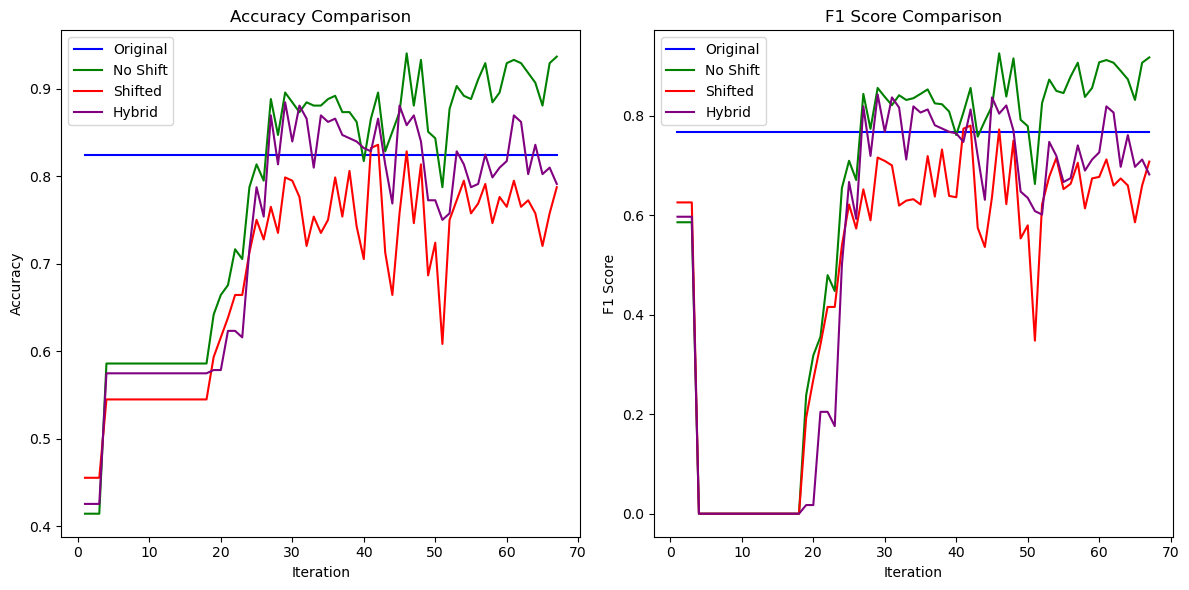

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Iterations:   0%|          | 0/19 [00:00<?, ?it/s]

In [13]:
all_accuracies = []
all_f1_scores = []

for i in range(100):

    if i > 0:
        trainer_hub.train(trainset)

    causal_model = trainer_hub.ccnet
    test_data = torch.tensor(testset.X).float().to(device)
    test_label = torch.tensor(testset.y).float().to(device)
    one_hot_labels = torch.nn.functional.one_hot(test_label.to(torch.long), num_classes=2).float().squeeze(-2)

    # Get the explanation
    explanation = causal_model.explain(test_data)
    
    # Shift size to scramble the explanation
    shift_length = len(explanation)//2
    
    shifted_explanation = torch.cat((explanation[shift_length:], explanation[:shift_length]), dim=0)
    hybrid_explanation = (explanation + shifted_explanation) / 2
    
    # Create synthetic datasets
    synthetic_data = [
        causal_model.produce(one_hot_labels, explanation),
        causal_model.produce(one_hot_labels, shifted_explanation),
        causal_model.produce(one_hot_labels, hybrid_explanation)]
    
    # Create the datasets with TemplateDataset class
    datasets = [TemplateDataset(test_data.cpu(), test_label.cpu())] + \
               [TemplateDataset(data.cpu(), test_label.cpu()) for data in synthetic_data]

    accuracies = []
    f1_scores = []
    # Test the model on the original and synthetic datasets
    for dataset in datasets:
        test_accuracy, test_f1 = test_model(model, dataset)
        accuracies.append(test_accuracy)
        f1_scores.append(test_f1)
    
    all_accuracies.append(accuracies)
    all_f1_scores.append(f1_scores)

    # Update the graph
    update_graph(all_accuracies, all_f1_scores, i)